## 분석할 것들
어떤 것을 분석해야 할까?

1. global 평균 독서 시간
2. 개인 독서 시간
3. 키워드 분석
4. 

$ V \approx S = \frac{D_p \times r}{T} \times F$  
$ B_r = 4.3 \times 1.35 $  
$ B_p : B_r = D_p : D_r$  
$ D_r = \frac{B_r \times D_p}{B_r} $  
$ r = \frac{B_r}{B_p}$

In [135]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from konlpy.tag import Twitter
from collections import Counter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rc('font', family='NanumGothic') # For Windows

In [2]:
font_location = "C:\\Users\\kyeul\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)

In [3]:
record = pd.read_csv('record.csv')

In [4]:
record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   타임스탬프                  162 non-null    object
 1   이름                     162 non-null    object
 2   독서_날짜                  162 non-null    object
 3   책 제목                   162 non-null    object
 4   시작 페이지                 162 non-null    int64 
 5   종료 페이지                 162 non-null    int64 
 6   쪽수                     162 non-null    int64 
 7   독서 시간(분단위, 단위는 입력  x)  162 non-null    int64 
 8   오늘의 문장                 140 non-null    object
 9   날짜                     162 non-null    object
dtypes: int64(4), object(6)
memory usage: 12.8+ KB


In [5]:
record.describe()

,시작 페이지,종료 페이지,쪽수,"독서 시간(분단위, 단위는 입력 x)"
count,162.000000,162.000000,162.000000,162.000000
mean,137.666667,171.802469,34.135802,30.135802
std,103.507494,103.666321,35.636799,22.917759
min,1.000000,8.000000,4.000000,5.000000
25%,56.000000,94.250000,15.000000,15.000000
50%,125.000000,162.500000,25.500000,26.000000
75%,201.500000,234.250000,42.000000,31.000000
max,513.000000,553.000000,323.000000,230.000000


# 전처리

어떤 data를 사용할 것인가. 
1. 날짜
2. 시간대 -> 개인이 주로 언제 책을 읽는지
3. 독서량
4. 독서시간 
5. 분당 독서량
6. 키워드

In [6]:
def makeAnnonimous(x):
    names = ['박한', '김동혁', '김효임', '박결', '김예지']
    annoni = ['member1', 'member2', 'member3', 'member4', 'member5']
    
    return annoni[names.index(x)]
    

In [7]:
record['이름'] = record['이름'].apply(lambda x: makeAnnonimous(x))

In [8]:
record.이름.unique()

array(['member1', 'member2', 'member3', 'member4', 'member5'],
      dtype=object)

In [9]:
def make24hour(x):
    lst = x.split(' ')[3:]
    time = int(lst[1].split(':')[0])
    
    if lst[0] == '오후':
        if time == 12:
            return time
        else:
            time += 12
        
    elif lst[0] == '오전' and time == 12:
        time = 0
    return time

In [10]:
record['타임스탬프'] = record['타임스탬프'].apply(lambda x: make24hour(x))

In [11]:
record.describe()

,타임스탬프,시작 페이지,종료 페이지,쪽수,"독서 시간(분단위, 단위는 입력 x)"
count,162.000000,162.000000,162.000000,162.000000,162.000000
mean,11.586420,137.666667,171.802469,34.135802,30.135802
std,8.914811,103.507494,103.666321,35.636799,22.917759
min,0.000000,1.000000,8.000000,4.000000,5.000000
25%,2.250000,56.000000,94.250000,15.000000,15.000000
50%,8.500000,125.000000,162.500000,25.500000,26.000000
75%,22.000000,201.500000,234.250000,42.000000,31.000000
max,23.000000,513.000000,553.000000,323.000000,230.000000


In [12]:
record.columns

Index(['타임스탬프', '이름', '독서_날짜', '책 제목', '시작 페이지', '종료 페이지', '쪽수',
       '독서 시간(분단위, 단위는 입력  x)', '오늘의 문장', '날짜'],
      dtype='object')

In [13]:
df = record[['타임스탬프', '이름', '책 제목', '쪽수', '독서 시간(분단위, 단위는 입력  x)', '오늘의 문장', '날짜']]

In [14]:
df=df.rename(columns = {'타임스탬프':'time-stamp', '이름':'user_name', '책 제목':'title','독서 시간(분단위, 단위는 입력  x)': 'reading-times', '쪽수':'reading-pages', '오늘의 문장':'daily_sentence', '날짜':'write_date'})

In [15]:
df.columns

Index(['time-stamp', 'user_name', 'title', 'reading-pages', 'reading-times',
       'daily_sentence', 'write_date'],
      dtype='object')

In [16]:
df.groupby('user_name').title.value_counts()

user_name  title                                                            
member1    생각하지 않는 사람들                                                          14
           이어쓰는 조경학개론                                                            5
           환경과 조경                                                                5
           나는 왜 집중하지 못하는가                                                        3
           꿈의 식물                                                                 2
           자연정원을 위한 꿈의 식물                                                        2
           존도어의 okr                                                              2
member2    성과를 부르는 영업의 기술 70                                                     9
           성공하는 한국인의 7가지 습관                                                      4
           생각하지 않는 사람들                                                           3
member3    멘탈의 연금술                                                               9
          

In [17]:
df[df['user_name']=='member1'].title.unique()

array(['이어쓰는 조경학개론', '자연정원을 위한 꿈의 식물', '꿈의 식물', '환경과 조경', '존도어의 okr',
       '생각하지 않는 사람들', '나는 왜 집중하지 못하는가'], dtype=object)

In [18]:
#독서 시간대 확인
df_time = df.groupby('user_name')['time-stamp'].value_counts().unstack().fillna(0).astype('int')
df_time

time-stamp,0,1,2,3,5,6,7,8,9,10,12,14,15,16,18,19,20,21,22,23
user_name,,,,,,,,,,,,,,,,,,,,
member1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,2,8,13,6
member2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,9
member3,12,8,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
member4,2,5,3,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,6,4
member5,2,0,0,0,1,7,16,12,9,1,2,1,2,1,0,0,0,0,4,4


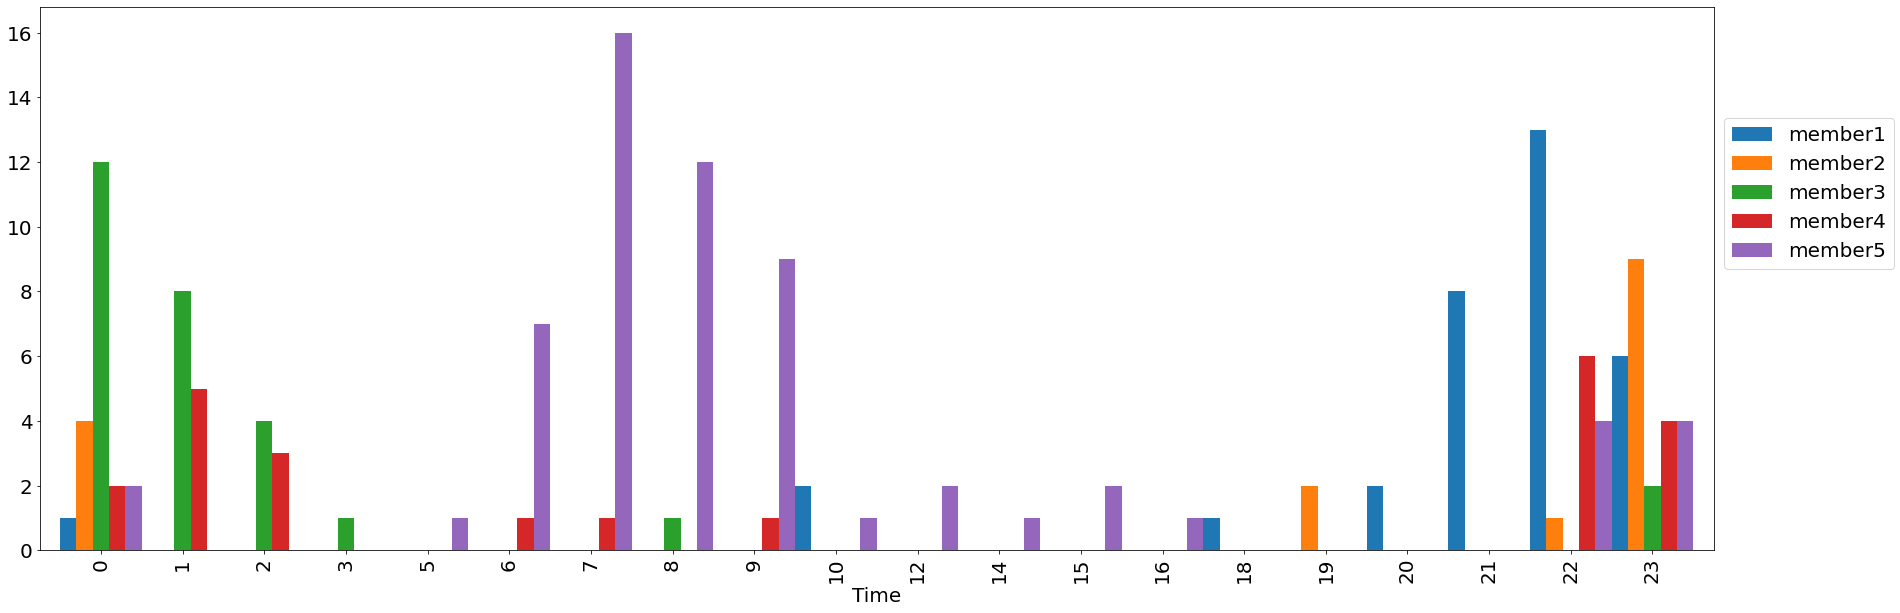

In [142]:
# 독서 시간대 바 차트로 그리기

df_time.T.plot.bar(width=1, figsize=(30, 10))
plt.rc('axes', labelsize=20)                                      
plt.rc('ytick', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xlabel('Time')
plt.show()

In [20]:
def get_day(date):
    
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    date = date.rstrip(' ')
    date = datetime.strptime(date, '%Y-%m-%d')
    day = date.weekday()
    return days[day]

In [21]:
df.head()

,time-stamp,user_name,title,reading-pages,reading-times,daily_sentence,write_date
0,22,member1,이어쓰는 조경학개론,17,20,NaN,2022. 3. 28
1,0,member2,성공하는 한국인의 7가지 습관,11,30,부분보다 전체를 보는 지혜,2022. 3. 29
2,0,member3,멘탈의 연금술,31,15,황금은 채굴되는 것이 아니다. 만들어지는 것이다.\n\n,2022. 3. 29
3,2,member4,"통계학, 빅데이터를 잡다",22,30,NaN,2022. 3. 29
4,7,member5,언스크립티드,32,60,"세상은 이미 당신의 것이지만, 그것을 손에 넣는 것은 당신의 몫이다",2022. 3. 29


In [22]:
date

datetime.date

In [23]:
df.write_date = df.write_date.apply(lambda x: re.sub('(\. )', '-', x))

In [24]:
df['day'] = df.write_date.apply(lambda x: get_day(x))

In [25]:
mPerDay=df.groupby('user_name').day.value_counts().unstack()

In [26]:
mPerDay=mPerDay[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

In [27]:
mPerDay.fillna(0).astype('int')

day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
user_name,,,,,,,
member1,6,4,5,2,6,3,7
member2,2,4,4,1,3,0,2
member3,2,5,3,5,5,3,5
member4,2,6,3,1,3,4,4
member5,7,10,8,12,8,7,10


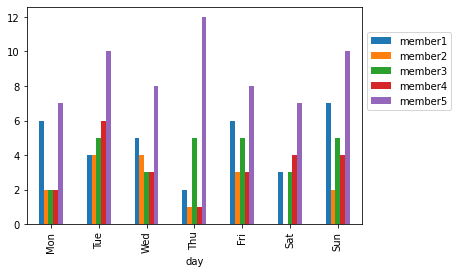

In [145]:
# 팀원 별 독서 횟수 비교
mPerDay.T.plot.bar()
# plt.rc('axes', labelsize=10)                                      
# plt.rc('ytick', labelsize=10)
# plt.rc('xtick', labelsize=10)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

In [29]:
df[df['user_name'] == 'member1'].title.unique()

array(['이어쓰는 조경학개론', '자연정원을 위한 꿈의 식물', '꿈의 식물', '환경과 조경', '존도어의 okr',
       '생각하지 않는 사람들', '나는 왜 집중하지 못하는가'], dtype=object)

In [30]:
df.groupby('user_name')['title'].nunique()

user_name
member1     7
member2     3
member3    10
member4     7
member5     9
Name: title, dtype: int64

In [31]:
df.columns

Index(['time-stamp', 'user_name', 'title', 'reading-pages', 'reading-times',
       'daily_sentence', 'write_date', 'day'],
      dtype='object')

In [280]:
# 특정 맴버가 읽은 시간대에 따른 독서 시간
data1=df[df['user_name'] =='member5'].groupby('time-stamp')['reading-times'].mean().astype('int')

<AxesSubplot:xlabel='time-stamp'>

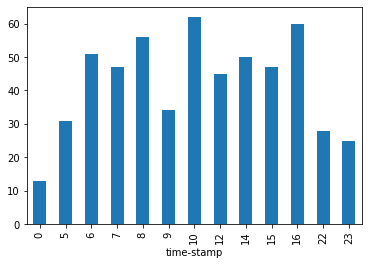

In [282]:
data1.plot.bar()

In [146]:
sent = ''
for i in df.daily_sentence:
    sent = sent +' ' + str(i)

In [147]:
sent

' nan 부분보다 전체를 보는 지혜 황금은 채굴되는 것이 아니다. 만들어지는 것이다.\n\n nan 세상은 이미 당신의 것이지만, 그것을 손에 넣는 것은 당신의 몫이다 nan nan 예측 가능한 삶을 살면 쉽게 무너지지 않는다. nan 당신의 목표가 천만 달러라면, 새로운 목표는 천만 달러의 가치를 창출하는 것이다 보편속에서의 다양함 인간을 움직이는 핵심동력 고통의회피 기쁨의 경험 당신은 내가 원하는 것을 가졌는가? 그렇다면 나는 얼마의 대가를 지불해야 그것을 가질 수 있는가? 추진력은 눈송이를 굴리는 일이다 nan nan 이 회사 -페이스북, 에어비앤비, 알리바바, 우버- 들은 소유하지 않고 통제한다 문제 해결의 규모는 당신이 벌 수 있는 돈의 규모다 한국 전통조경 = 풍수지리학 nan 나 지금 걱정있어가 아닌 나 지금 해결해야 할 일 있어로 당신의 첫 실행 과제는 시장의 마음을 예단하는 것이 아니라 (되도록이면 적은 비용을 들여서) 현장에 뛰어들어서 시장을 읽는 노력을 하는 것이다 nan 걱정이 닥칠 땐 잠시 멈춰라 여러 우물을 파기 전에 반드시 한 우물에서 성공해야 한다 오늘은 소중한 당신의 것이다 nan nan 두려움을 다루는 최상의 방법은 적극적인 행동이다 nan nan 꿈꾸고. 실패하고, 교훈을 배우고, 마침내는 성공했다 고수는 자기 자신을 믿는다. 어떤 생각이든 감정 및 믿음과 결합되면. 그 즉시 그것과 동등한 물리적 형태로 바뀌게 된다.  nan 판매자측과 구매자측의 관심을 파악하고, 고용주들이 추가로 비용을 지불할 만한 가치를 담은 계획을 제시한다 고수는 고객이 원하는 것을 준비한다. nan 고객은 당신에게 먼저 전화하지 않는다. 성공한 사람은 즉시 결정을 내리는 것이 습관화되어 있고 그 결정을 바꿀 때는 오랜 시간 신중하게 생각한다는 사실을 알았다. 부를 일구는 데 실패한 사람들은 거의 예외 없이 결단을 내리는 데는 오랜 시간이 걸리는 반면, 결정을 무척이나 빠르고도 자주 뒤집었다. nan nan 끈기가 실패를 과거의 일로 만든다 nan n

In [35]:
twitter = Twitter()

C:\Users\kyeul\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [37]:
sentences_tag = []
sentences_tag = twitter.pos(sent) 

In [237]:
stopwords = ['것', '있는', '수', '그', '더', '모든', '데', '내', '때', '당신', '할', '한다', '이','그것',
            '대한', '어떤', '즉시', '있는가', 'nan','사람','우리','사실','나','있다','때문', '아니라', '위해']

In [238]:
noun_adj_list = []
# tag가 명사이거나 형용사인 단어들만 noun_adj_list에 넣어준다.
for word, tag in sentences_tag:
    if tag in ['Noun' , 'Adjective'] and word not in stopwords: 
        noun_adj_list.append(word)


In [239]:
# 가장 많이 나온 단어부터 40개를 저장한다.
counts = Counter(noun_adj_list)
tags = dict(counts.most_common(50))

In [240]:
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(12,313),np.random.randint(0,32),np.random.randint(45,80)))

In [241]:
wc = WordCloud(font_path='malgun', 
               width=400, height=400, scale=2.0, 
               background_color='#FFFFFF',
               max_font_size=250, 
               color_func = color_func
              )


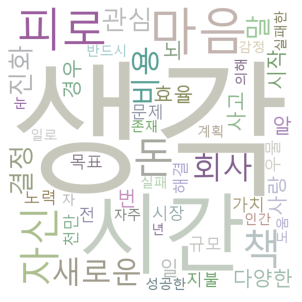

In [242]:
gen = wc.generate_from_frequencies(tags)
plt.figure()
plt.axis('off')
plt.imshow(gen)
plt.tight_layout(pad=0)
plt.show()

In [307]:
data = df[df['user_name']=="member5"][["write_date", "reading-times"]]
data.set_index(data['write_date'], inplace=True)
data5 = data.drop('write_date', axis=1)

In [312]:
plt.bar(data1, label="member1")
plt.bar(data2, label='member2')
plt.bar(data3, label='member3')
plt.bar(data4, label='member4')
plt.bar(data5, label='member5')
plt.legend()
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'